## 动态图转静态图训练

- 飞桨的动转静方式是基于源代码级别转换的ProgramTranslator实现，其原理是通过分析Python代码，将动态图代码转写为静态图代码，并在底层自动使用静态图执行器运行。
- 动转静的基本使用方法，只需要在要转化的函数（该函数也可以是用户自定义动态图Layer的forward函数）前添加一个装饰器 @paddle.jit.to_static，这种转换方式使得可以灵活使用Python语法及其控制流来构建神经网络模型。

In [1]:
import paddle
import paddle.nn.functional as F
# 确保从paddle.vision.datasets.MNIST中加载的图像数据是np.ndarray类型
paddle.vision.set_image_backend('cv2')

# 定义手写数字识别模型
class MNIST(paddle.nn.Layer):
    def __init__(self):
        super(MNIST, self).__init__()
        
        # 定义一层全连接层，输出维度是1
        self.fc = paddle.nn.Linear(in_features=784, out_features=10)

    # 定义网络结构的前向计算过程
    @paddle.jit.to_static  # 添加装饰器，使动态图网络结构在静态图模式下运行
    def forward(self, inputs):
        outputs = self.fc(inputs)
        return outputs

In [2]:
# 图像归一化函数，将数据范围为[0, 255]的图像归一化到[-1, 1]
def norm_img(img):
    batch_size = img.shape[0]
    # 归一化图像数据
    img = img/127.5 - 1
    # 将图像形式reshape为[batch_size, 784]
    img = paddle.reshape(img, [batch_size, 784])
    
    return img

In [3]:
def train(model):
    model.train()
    # 加载训练集 batch_size 设为 16
    train_loader = paddle.io.DataLoader(paddle.vision.datasets.MNIST(mode='train'), 
                                        batch_size=16, 
                                        shuffle=True)
    opt = paddle.optimizer.SGD(learning_rate=0.001, parameters=model.parameters())
    EPOCH_NUM = 10
    for epoch in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            images = norm_img(data[0]).astype('float32')
            labels = data[1].astype('int64')
            
            #前向计算的过程
            predicts = model(images)
            
            # 计算损失
            loss = F.cross_entropy(predicts, labels)
            avg_loss = paddle.mean(loss)
            
            #每训练了1000批次的数据，打印下当前Loss的情况
            if batch_id % 1000 == 0:
                print("epoch_id: {}, batch_id: {}, loss is: {}".format(epoch, batch_id, avg_loss.numpy()))
            
            #后向传播，更新参数的过程
            avg_loss.backward()
            opt.step()
            opt.clear_grad()

In [4]:
model = MNIST() 

train(model)

paddle.save(model.state_dict(), './mnist.pdparams')
print('Trained model saved in ./mnist.pdparams')

epoch_id: 0, batch_id: 0, loss is: [3.3005857]
epoch_id: 0, batch_id: 1000, loss is: [0.7897545]
epoch_id: 0, batch_id: 2000, loss is: [0.5859482]
epoch_id: 0, batch_id: 3000, loss is: [1.057006]
epoch_id: 1, batch_id: 0, loss is: [0.67698306]
epoch_id: 1, batch_id: 1000, loss is: [0.446375]
epoch_id: 1, batch_id: 2000, loss is: [0.38303977]
epoch_id: 1, batch_id: 3000, loss is: [0.56168306]
epoch_id: 2, batch_id: 0, loss is: [0.22864169]
epoch_id: 2, batch_id: 1000, loss is: [0.48306552]
epoch_id: 2, batch_id: 2000, loss is: [0.45017353]
epoch_id: 2, batch_id: 3000, loss is: [0.42036504]
epoch_id: 3, batch_id: 0, loss is: [0.2420464]
epoch_id: 3, batch_id: 1000, loss is: [0.7084192]
epoch_id: 3, batch_id: 2000, loss is: [0.16424029]
epoch_id: 3, batch_id: 3000, loss is: [0.41065025]
epoch_id: 4, batch_id: 0, loss is: [0.43705136]
epoch_id: 4, batch_id: 1000, loss is: [0.40018773]
epoch_id: 4, batch_id: 2000, loss is: [0.866436]
epoch_id: 4, batch_id: 3000, loss is: [0.19154721]
epoch_

## 动态图转静态图模型保存

- 在推理&部署场景中，需要同时保存推理模型的结构和参数，但是动态图是即时执行即时得到结果，并不会记录模型的结构信息
- 动态图在保存推理模型时，需要先将动态图模型转换为静态图写法，编译得到对应的模型结构再保存
- paddle.jit.save和paddle.jit.load接口，无需重新实现静态图网络结构，直接实现动态图模型转成静态图模型格式
- paddle.jit.save接口会自动调用动态图转静态图功能，使得用户可以做到使用动态图编程调试，自动转成静态图训练部署

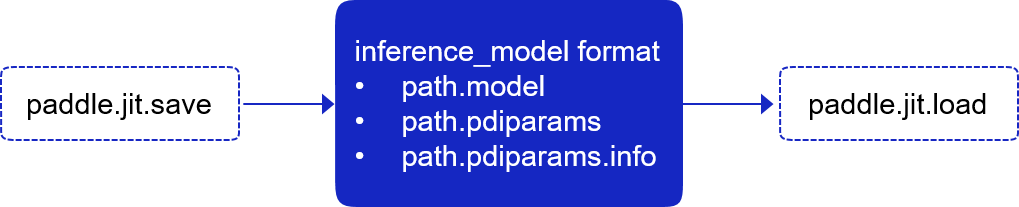

In [6]:
# save inference model
from paddle.static import InputSpec

# 加载训练好的模型参数
state_dict = paddle.load("./mnist.pdparams")

# 将训练好的参数读取到网络中
model.set_state_dict(state_dict)

# 设置模型为评估模式
model.eval()

# 保存inference模型
paddle.jit.save(
    layer=model,
    path="inference/mnist",
    input_spec=[InputSpec(shape=[None, 784], dtype='float32')])

print('Inference model saved in inference/mnist.')

Inference model saved in inference/mnist.


- paddle.jit.save API 将输入的网络存储为 paddle.jit.TranslatedLayer 格式的模型，载入后可用于预测推理或者fine-tune训练
- 该接口会将输入网络转写后的模型结构 Program 和所有必要的持久参数变量存储至输入路径 path
- path 是存储目标的前缀，存储的模型结构 Program 文件的后缀为 .pdmodel ，存储的持久参数变量文件的后缀为 .pdiparams ，同时也会将一些变量描述信息存储至文件，文件后缀为 .pdiparams.info
- paddle.jit.save API 可以把输入的网络结构和参数固化到一个文件中，所以通过加载保存的模型，可以不用重新构建网络结构而直接用于预测，易于模型部署

In [8]:
# 通过调用对应的paddle.jit.load接口，可以把存储的模型载入为 paddle.jit.TranslatedLayer格式，用于预测推理或者fine-tune训练

# 读取mnist测试数据，获取第一个数据
mnist_test = paddle.vision.datasets.MNIST(mode='test')
test_image, label = mnist_test[0]

# 获取读取到的图像的数字标签
print("The label of readed image is : ", label)

# 将测试图像数据转换为tensor，并reshape为[1, 784]
test_image = paddle.reshape(paddle.to_tensor(test_image), [1, 784])

# 然后执行图像归一化
test_image = norm_img(test_image)

# 加载保存的模型
loaded_model = paddle.jit.load("./inference/mnist")

# 利用加载的模型执行预测
preds = loaded_model(test_image)
pred_label = paddle.argmax(preds)

# 打印预测结果
print("The predicted label is : ", pred_label.numpy())

The label of readed image is :  [7]
The predicted label is :  [7]
